<a href="https://colab.research.google.com/github/stepan-zykov/DLS/blob/main/GAN/HW9_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial network. Генерация лиц

## Цель:
обучить GAN генерировать лица людей и посмотреть на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline
from math import ceil

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому будет использована его часть. [Ссылка на используемый датасет](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory)

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/MyDrive/DLS/HW/HW9_GAN/')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/DLS/HW/HW9_GAN'

In [ ]:
DATA_DIR = './faces'

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'Flickr-Faces-HQ (FFHQ) small'

ref                             title                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------  ----------------------------  ----  -------------------  -------------  ---------  ---------------  
tommykamaz/faces-dataset-small  Flickr-Faces-HQ (FFHQ) small   4GB  2022-05-23 17:12:59           1797         18  0.875            


In [ ]:
! kaggle datasets download -d 'tommykamaz/faces-dataset-small'

100% 3.98G/3.99G [01:07<00:00, 92.2MB/s]
100% 3.99G/3.99G [01:07<00:00, 63.6MB/s]


In [ ]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!unzip faces-dataset-small.zip

In [ ]:
directory = 'faces_dataset_small'

Создадим татасет и даталоудер

In [ ]:
image_size = 64
batch_size = 32

my_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
    ])

faces_dataset = ImageFolder(directory, transform=my_transform)
data_loader = DataLoader(faces_dataset, batch_size=batch_size, shuffle=True)

Посмотрим на изображения, с которыми нам предстоит работать

In [ ]:
def denorm(img_tensors):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_pictures(pictures):
    rows = ceil(len(pictures)/5)
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.flatten()
    for i, photo in enumerate(pictures):
      axes[i].imshow(photo.permute(1, 2, 0))
      axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
batch = next(iter(data_loader))

In [ ]:
batch[0].shape

torch.Size([32, 3, 64, 64])

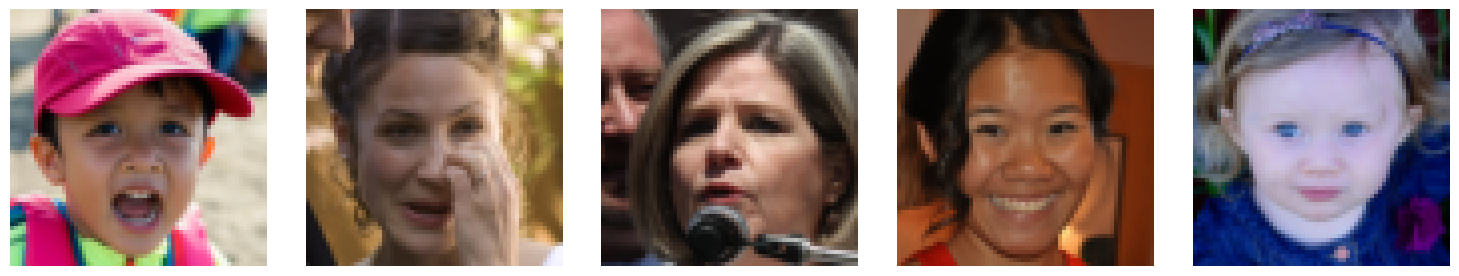

In [ ]:
show_pictures(batch[0][:5])

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор.
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
lr = 0.0002
epochs = 5

model = {
    'discriminator': discriminator.to(device),
    'generator': generator.to(device)
}

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

# Проверим работоспособность моделей

## Дискриминатор

In [ ]:
batch = batch[0].to(device)
batch.shape


torch.Size([32, 3, 64, 64])

In [ ]:
model['discriminator'](batch)

tensor([[0.4055],
        [0.5123],
        [0.4147],
        [0.4382],
        [0.5270],
        [0.3738],
        [0.4921],
        [0.5439],
        [0.5917],
        [0.5018],
        [0.5396],
        [0.3200],
        [0.3603],
        [0.5804],
        [0.6183],
        [0.6145],
        [0.4232],
        [0.4041],
        [0.6121],
        [0.4029],
        [0.5357],
        [0.5506],
        [0.5762],
        [0.4848],
        [0.5529],
        [0.6812],
        [0.7193],
        [0.5515],
        [0.6102],
        [0.5086],
        [0.2920],
        [0.5439]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Необученный дискриминатор предсказуемо выдает что-то среднее между 0 и 1

## Генератор

In [ ]:
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
generated = model['generator'](latent)
generated.shape

torch.Size([32, 3, 64, 64])

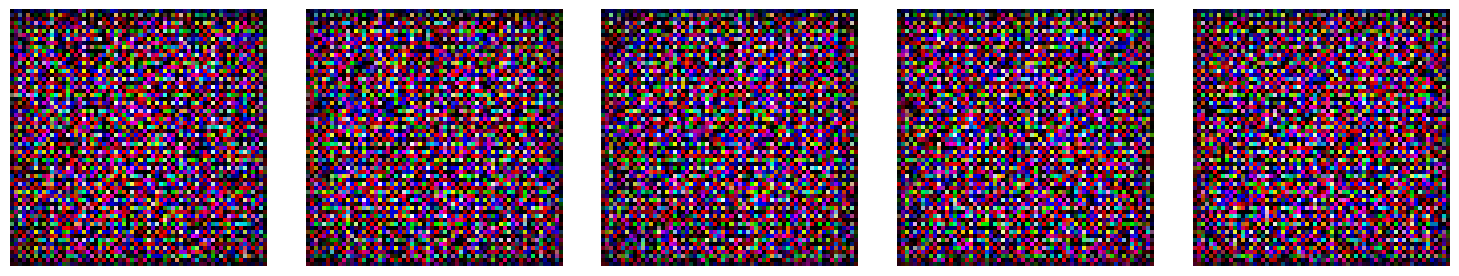

In [ ]:
show_pictures(generated.cpu().detach()[:5])

Необученный генератор предсказуемо генерирует шум

# Обучение дискриминатора и генератора

In [ ]:
def fit(model, criterion, epochs, lr):
    model['discriminator'].train()
    model['generator'].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_generator = []
    losses_discriminator = []
    real_scores = []
    fake_scores = []

    # create optimizers
    optimizer = {'discriminator': torch.optim.Adam(model['discriminator'].parameters(),
                                                   lr=lr, betas=(0.5, 0.999)),
                 'generator': torch.optim.Adam(model['generator'].parameters(),
                                               lr=lr, betas=(0.5, 0.999))}

    for epoch in range(epochs):
        loss_discriminator_per_epoch = []
        loss_generator_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(data_loader):
            #train discriminator
            # clear discriminator gradients
            optimizer['discriminator'].zero_grad()

            # pass real images through discriminator
            real_images = real_images.to(device)
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)

            # pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # update discriminator weight
            loss_discriminator = real_loss + fake_loss
            loss_discriminator.backward()
            optimizer['discriminator'].step()
            loss_discriminator_per_epoch.append(loss_discriminator.item())

            # train generator
            optimizer['generator'].zero_grad()

            # generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)

            # try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_generator = criterion['generator'](preds, targets)

            # Update generator weights
            loss_generator.backward()
            optimizer['generator'].step()
            loss_generator_per_epoch.append(loss_generator.item())

        losses_generator.append(np.mean(loss_generator_per_epoch))
        losses_discriminator.append(np.mean(loss_discriminator_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last_batch)
        print("Epoch [{}/{}], loss_generator: {:.4f}, loss_discriminator: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, losses_generator[-1], losses_discriminator[-1], real_scores[-1], fake_scores[-1]))

    return losses_generator, losses_discriminator, real_scores, fake_scores


In [ ]:
epochs = 20
history = fit(model, criterion, epochs, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/20], loss_generator: 4.8829, loss_discriminator: 0.4548, real_score: 0.8617, fake_score: 0.1413


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/20], loss_generator: 4.8813, loss_discriminator: 0.5734, real_score: 0.8271, fake_score: 0.1721


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/20], loss_generator: 4.3762, loss_discriminator: 0.6257, real_score: 0.8066, fake_score: 0.1897


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/20], loss_generator: 4.4805, loss_discriminator: 0.6298, real_score: 0.8056, fake_score: 0.1996


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/20], loss_generator: 4.5379, loss_discriminator: 0.5425, real_score: 0.8204, fake_score: 0.1740


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/20], loss_generator: 4.3171, loss_discriminator: 0.6285, real_score: 0.8038, fake_score: 0.1967


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/20], loss_generator: 4.4293, loss_discriminator: 0.5201, real_score: 0.8271, fake_score: 0.1737


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/20], loss_generator: 4.6446, loss_discriminator: 0.6032, real_score: 0.8138, fake_score: 0.1822


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/20], loss_generator: 4.3007, loss_discriminator: 0.5361, real_score: 0.8207, fake_score: 0.1777


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/20], loss_generator: 3.9138, loss_discriminator: 0.5624, real_score: 0.8116, fake_score: 0.1836


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/20], loss_generator: 4.1840, loss_discriminator: 0.4635, real_score: 0.8363, fake_score: 0.1614


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/20], loss_generator: 4.2117, loss_discriminator: 0.5144, real_score: 0.8278, fake_score: 0.1710


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/20], loss_generator: 4.2867, loss_discriminator: 0.5116, real_score: 0.8343, fake_score: 0.1602


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/20], loss_generator: 3.9533, loss_discriminator: 0.5294, real_score: 0.8239, fake_score: 0.1699


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/20], loss_generator: 4.2820, loss_discriminator: 0.4148, real_score: 0.8580, fake_score: 0.1481


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/20], loss_generator: 4.3027, loss_discriminator: 0.4411, real_score: 0.8518, fake_score: 0.1440


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/20], loss_generator: 4.3976, loss_discriminator: 0.4402, real_score: 0.8470, fake_score: 0.1478


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/20], loss_generator: 3.9550, loss_discriminator: 0.5188, real_score: 0.8305, fake_score: 0.1693


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/20], loss_generator: 4.0908, loss_discriminator: 0.4297, real_score: 0.8582, fake_score: 0.1411


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/20], loss_generator: 4.4075, loss_discriminator: 0.4069, real_score: 0.8604, fake_score: 0.1335


Нарисуем графики лоссов генератора и дискриминатора

In [ ]:
def losses_scores_chart(first, second, loss=True):
    """
    Функция получает списки лоссов или скоров и отрисовывает графики
    """
    epochs = len(first)
    if loss:
        plt.plot(range(1, epochs + 1), first, label='Generator loss')
        plt.plot(range(1, epochs + 1), second, label='Discriminator loss')
        plt.title("Generator and discriminator loss over epochs")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    else:
        plt.plot(range(1, epochs + 1), first, label='Real_score')
        plt.plot(range(1, epochs + 1), second, label='Fake_score')
        plt.title("Real and fake scores over epochs")
        plt.xlabel('Epoch')
        plt.ylabel('Score')
    plt.legend()
    plt.show()

In [ ]:
losses_generator, losses_discriminator, real_scores, fake_scores = history

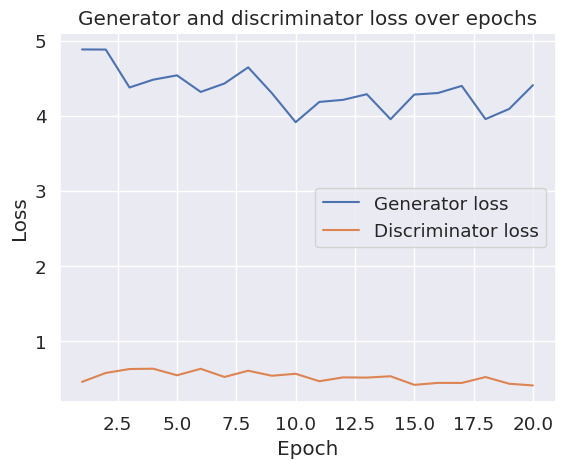

In [ ]:
losses_scores_chart(losses_generator, losses_discriminator, True)

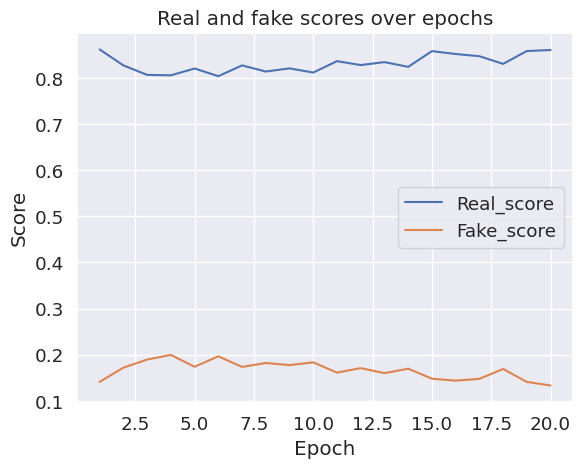

In [ ]:
losses_scores_chart(real_scores, fake_scores, False)

Accuracy показывает, что дискриминатор хорошо отличает настоящие изображения от сгенерированных. В идеале мы бы хотели, чтобы дискриминатор угадывал в 50 % случаев, однако добиться такого результата простой сетью не удастся.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 10
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

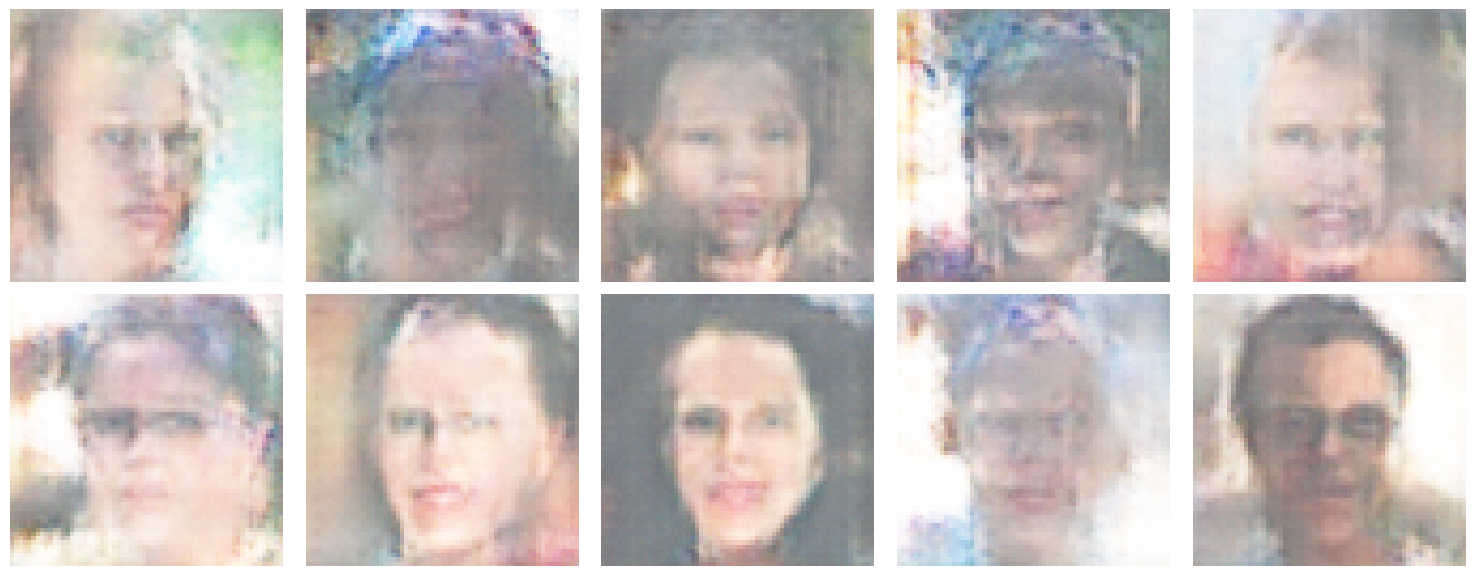

In [ ]:
show_pictures(denorm(fake_images.cpu().detach()))

Модель смогла сгенерировать лица, хотя, конечно, есть куда стремиться

In [ ]:
torch.save(model['generator'].state_dict(), 'my_generator.pt')
torch.save(model['discriminator'].state_dict(), 'discriminator.pt')

In [ ]:
model['generator'].load_state_dict(torch.load('my_generator.pt', map_location=device))
model['discriminator'].load_state_dict(torch.load('discriminator.pt', map_location=device))
model['generator'] = model['generator'].to(device)
model['discriminator'] = model['discriminator'].to(device)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

Генерируем столько же изображений, сколько есть в обучающей выборке

In [ ]:
latent_features = torch.randn(len(faces_dataset), latent_size, 1, 1).to(device)

In [ ]:
generated_images = model['generator'](latent_features)

Задаем метки классов

In [ ]:
fake_labels = torch.zeros(generated_images.shape[0], 1)
fake_labels.shape

torch.Size([3143, 1])

In [ ]:
true_labels = torch.ones(len(faces_dataset), 1)

Объединяем тренировочные и сгенерированные картинки и их классы

In [ ]:
all_labels = torch.concatenate((true_labels, fake_labels))
all_labels.shape

torch.Size([6286, 1])

In [ ]:
real_images = []
for image, _ in tqdm(faces_dataset):
    real_images.append(image)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
len(real_images)

3143

In [ ]:
real_images = torch.stack(real_images)
real_images.shape

torch.Size([3143, 3, 64, 64])

In [ ]:
generated_images.shape

torch.Size([3143, 3, 64, 64])

In [ ]:
all_images = torch.concatenate((real_images.to(device), generated_images))
all_images.shape

torch.Size([6286, 3, 64, 64])

Перемешаем данные. Используем только 500 объектов, чтобы ускорить процесс

In [ ]:
idxs = np.arange(all_images.shape[0])
np.random.shuffle(idxs)

In [ ]:
idxs = idxs[:500]

In [ ]:
idxs[:10]

array([2178, 5881, 4590,  697, 4420,   59,  746, 1102,  973, 4928])

In [ ]:
idxs.shape

(500,)

In [ ]:
cv_images = all_images.view(6286, -1).cpu().detach().numpy()[idxs]
cv_images.shape

(500, 12288)

In [ ]:
cv_labels = all_labels.cpu().detach().numpy().ravel()[idxs]
cv_labels.shape

(500,)

Найдем Accuracy

In [ ]:
cv_score = cross_val_score(knn, cv_images, cv_labels, scoring='accuracy', n_jobs=-1, cv=cv, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.6s finished


Среднее

In [ ]:
cv_score.mean()

0.746

Стандартное отклонение

In [ ]:
cv_score.std()

0.4352975993501457

Дополнительное подтверждение того, что классификатор справляется и хорошо отличает сгенерированные изображения от истинных.

### 4.2. Визуализация распределений

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуемся методом, снижающим размерность (TSNE)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()
tsne_result = tsne.fit_transform(cv_images)

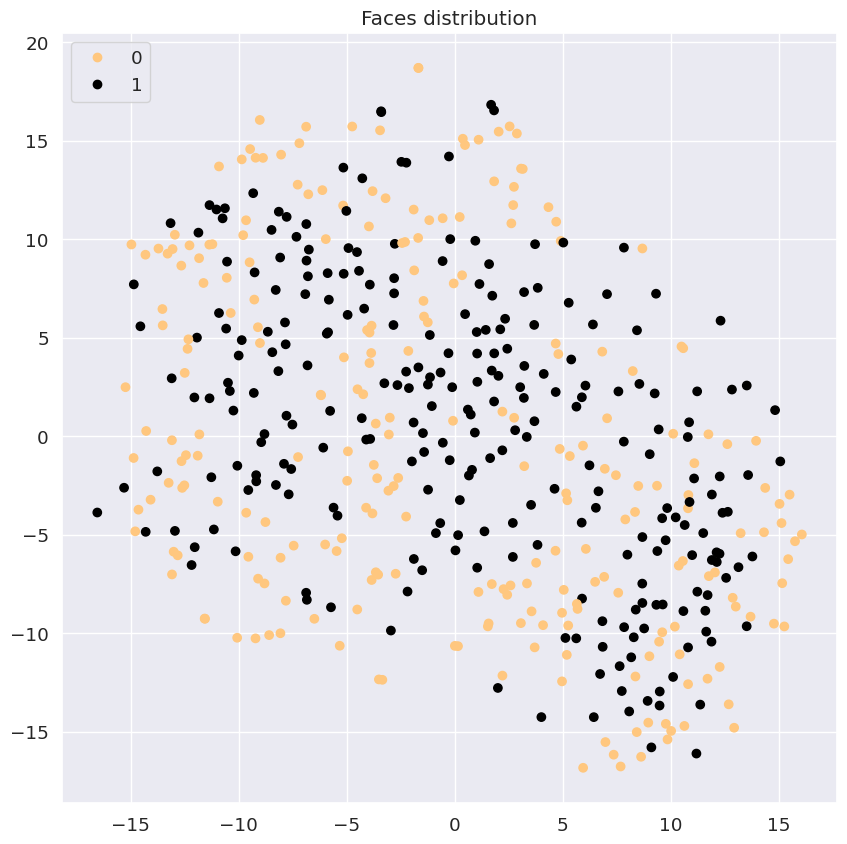

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, title='Faces distribution')
scatter = ax.scatter(
    x=tsne_result[:,0],
    y=tsne_result[:,1],
    c=cv_labels,
    cmap='copper_r'
)
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()